#**Importing Libraries**

In [1]:
import numpy as np
import cv2
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Conv2D, Flatten, MaxPooling2D,Dense,Dropout,BatchNormalization
from keras.models  import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import random,os,glob
import matplotlib.pyplot as plt
import shutil
from keras.applications import ResNet50V2, VGG16
import pandas as pd
from sklearn.metrics import confusion_matrix
from keras import models
from keras.optimizers import SGD, Nadam
import seaborn as sns
import random, os
from PIL import Image

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#**Mounting Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#**Extracting the dataset**

In [0]:
import os
import zipfile

BASE_PATH = '/content'

def extract_dataset(path):
  #Extracting the dataset from the zip file
  zip_ref = zipfile.ZipFile(path, 'r')
  zip_ref.extractall(BASE_PATH)
  zip_ref.close()

In [4]:
extract_dataset('/content/drive/My Drive/Garbage classification.zip')
os.listdir(os.path.join(os.getcwd(),"Garbage classification"))

['plastic', 'paper', 'cardboard', 'glass', 'trash', 'metal']

#**Dividing the dataset**
Defining the functions


In [0]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.7*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## divide remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.4*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

Creating Train, Validation and Test dataset

In [0]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid', 'test']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
folder= os.path.join('data/Random 4x4')
os.makedirs(folder)

## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('Garbage classification',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    test_dest = "data/test/"+waste_type
    move_files(test_source_files, test_dest)

# **Image Augmentation**


In [7]:
image_size=224
image_augment=ImageDataGenerator(horizontal_flip=True, vertical_flip=True,rescale=1./255,
                         shear_range = 0.1,zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,)


#-----------------------------------------------------------------------------------------

train_generator = image_augment.flow_from_directory(
                                        directory="data/train/",
                                        target_size=(image_size, image_size),
                                        batch_size=32,
                                        color_mode= 'rgb',
                                        class_mode="categorical", #try using  sparse
                                        shuffle=False,
                                        seed=42)

validation_generator =  image_augment.flow_from_directory(
                                        directory="data/valid/",
                                        target_size=(image_size, image_size),
                                        batch_size=32,
                                        color_mode= 'rgb',
                                        class_mode="categorical",
                                        shuffle=False,
                                        seed=42)

test_generator = image_augment.flow_from_directory(
                                        directory="data/test/",
                                        target_size=(image_size, image_size),
                                        batch_size=32,
                                        color_mode= 'rgb',
                                        class_mode="categorical",
                                        shuffle=False,
                                        seed=42)


#-------------------------------------------------------------------------------------------


Found 1766 images belonging to 6 classes.
Found 302 images belonging to 6 classes.
Found 459 images belonging to 6 classes.


#**CNN**

Model Building

In [9]:
#------------------------------------- CNN  -----------------------------------

model=Sequential()

model.add(Conv2D(32,(3,3), padding='same', input_shape=(image_size,image_size,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) 
model.add(Conv2D(64,(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) 
model.add(Conv2D(32,(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) 
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6,activation='softmax'))  # 1

#-------------- Epoch= 94 loss: 1.0536 - acc: 0.5865 - val_loss: 1.1179 - val_acc: 0.6710 ------------------ Conv 32 x 64 x 32--

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)            

In [10]:
train_step = train_generator.n//train_generator.batch_size
val_step = validation_generator.n//validation_generator.batch_size
print("Train step: ", train_step)
print("Validation step: ", val_step)

Train step:  55
Validation step:  9


 Model training

In [11]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc = ModelCheckpoint('cnn_checkpoint.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

cnn = model.fit(train_generator, epochs=100, steps_per_epoch=train_step,validation_data=validation_generator,
                    validation_steps=val_step, callbacks = [mc])


Epoch 1/100
55/55 [==============================] - 30s 539ms/step - loss: 1.9256 - acc: 0.1661 - val_loss: 1.7917 - val_acc: 0.2465

Epoch 00001: val_acc improved from -inf to 0.24653, saving model to cnn_checkpoint.h5
Epoch 2/100
55/55 [==============================] - 28s 511ms/step - loss: 1.8037 - acc: 0.2047 - val_loss: 1.7985 - val_acc: 0.2778

Epoch 00002: val_acc improved from 0.24653 to 0.27778, saving model to cnn_checkpoint.h5
Epoch 3/100
55/55 [==============================] - 28s 506ms/step - loss: 1.8271 - acc: 0.1471 - val_loss: 1.4464 - val_acc: 0.2222

Epoch 00003: val_acc did not improve from 0.27778
Epoch 4/100
55/55 [==============================] - 27s 493ms/step - loss: 1.7996 - acc: 0.2584 - val_loss: 1.8710 - val_acc: 0.2222

Epoch 00004: val_acc did not improve from 0.27778
Epoch 5/100
55/55 [==============================] - 27s 493ms/step - loss: 1.8127 - acc: 0.2261 - val_loss: 1.7850 - val_acc: 0.1444

Epoch 00005: val_acc did not improve from 0.27778


Saving the model

In [0]:
model.save('/content/drive/My Drive/My Models/cnn.h5')
#cnn_1= models.load_model('/content/drive/My Drive/My Models/cnn.h5')

In [16]:
cnn.model.evaluate_generator(train_generator)

[1.8181825876235962, 0.5702151656150818]

In [18]:
cnn.model.evaluate_generator(validation_generator)

[2.2963004112243652, 0.559602677822113]

In [20]:
cnn.model.evaluate_generator(test_generator)

[2.0981407165527344, 0.5250544548034668]

Visualizing Accuracy and Loss 

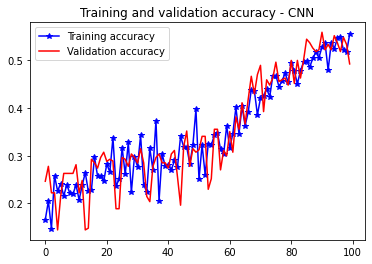

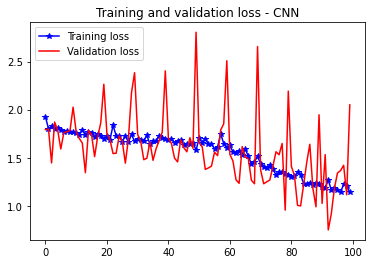

In [21]:
val_acc = cnn.history['val_acc']
val_loss = cnn.history['val_loss']
acc = cnn.history['acc']
loss = cnn.history['loss']

# Plot training & validation accuracy values
plt.plot(range(100), acc, 'b*-', label = 'Training accuracy')
plt.plot(range(100), val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy - CNN')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(range(100), loss, 'b*-', label = 'Training loss')
plt.plot(range(100), val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss - CNN')
plt.legend()
plt.show()

#**Prediction using test set**

In [22]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=model.predict(test_generator, verbose=1)

15/15 [==============================] - 6s 414ms/step


In [0]:
predicted_class_indices=np.argmax(pred,axis=1)

In [0]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

predictions = [labels[k] for k in predicted_class_indices]

In [0]:
file_names=test_generator.filenames
for i in range(0,len(file_names)):
  file_names[i] = file_names[i].split('/')
  file_names[i] = file_names[i][0]


classes= (test_generator.class_indices)


for i in range(0,len(file_names)):
  if file_names[i] in classes:
    file_names[i]=classes[file_names[i]]

for i in range(0,len(predictions)):
  if predictions[i] in classes:
    predictions[i]=classes[predictions[i]]


In [26]:
results=pd.DataFrame({"Actual":file_names,
                      "Predictions":predictions})
results.head(5)

,Actual,Predictions
0,0,0
1,0,0
2,0,0
3,0,2
4,0,5


In [27]:
cm = confusion_matrix(file_names, predictions)
print(cm)

[[52  3  5  8  3  2]
 [ 2 36 19 12 22  0]
 [ 1 16 36  7 11  3]
 [ 1  6  9 63 29  0]
 [ 1  7 12  7 59  1]
 [ 1  6  5  3  6  5]]


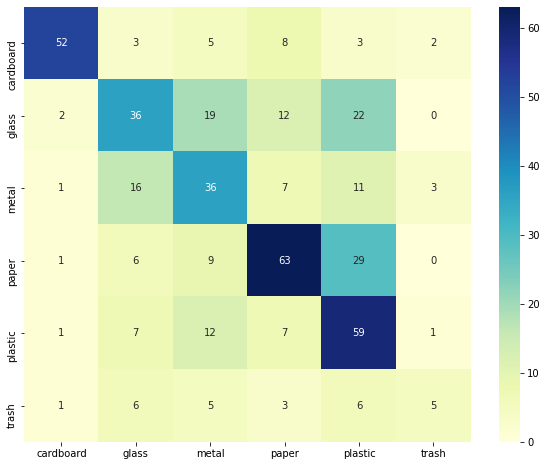

In [28]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [29]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

accuracy = correct/sum(sum(cm))
accuracy

0.5468409586056645

#**ResNet50 - PreTrained**
Defining ResNet50



In [30]:
resnet_pretrained = ResNet50V2(include_top=False,
                             weights='imagenet',
                             pooling='avg')



94674944/94668760 [==============================] - 8s 0us/step


Model Building


In [31]:
model = Sequential()

model.add(resnet_pretrained)
model.add(Dense(6, activation='softmax'))

#Fine-tuning
# Freeze the first layer
model.layers[0].trainable = False

lr = 0.01
momentum = 0.001
opt = SGD(learning_rate=lr, momentum=momentum)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 12294     
Total params: 23,577,094
Trainable params: 12,294
Non-trainable params: 23,564,800
_________________________________________________________________


In [32]:
train_step = train_generator.n//train_generator.batch_size
val_step = validation_generator.n//validation_generator.batch_size
print("Train step: ", train_step)
print("Validation step: ", val_step)

Train step:  55
Validation step:  9


Model Training

In [34]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('resnet-pretrained_checkpoint.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

resnet_pretrained = model.fit(train_generator,
                   steps_per_epoch=train_step,
                   validation_data=validation_generator,
                   validation_steps=val_step,
                   epochs=50,
                   callbacks=[mc])

Epoch 1/50
55/55 [==============================] - 34s 610ms/step - loss: 1.7586 - accuracy: 0.3287 - val_loss: 3.6723 - val_accuracy: 0.4965

Epoch 00001: val_accuracy improved from -inf to 0.49653, saving model to resnet-pretrained_checkpoint.h5
Epoch 2/50
55/55 [==============================] - 33s 602ms/step - loss: 1.7916 - accuracy: 0.3120 - val_loss: 1.8245 - val_accuracy: 0.4926

Epoch 00002: val_accuracy did not improve from 0.49653
Epoch 3/50
55/55 [==============================] - 33s 597ms/step - loss: 1.6693 - accuracy: 0.3766 - val_loss: 1.3290 - val_accuracy: 0.3963

Epoch 00003: val_accuracy did not improve from 0.49653
Epoch 4/50
55/55 [==============================] - 32s 587ms/step - loss: 1.6991 - accuracy: 0.3529 - val_loss: 0.2529 - val_accuracy: 0.4222

Epoch 00004: val_accuracy did not improve from 0.49653
Epoch 5/50
55/55 [==============================] - 32s 585ms/step - loss: 1.7207 - accuracy: 0.3403 - val_loss: 1.2648 - val_accuracy: 0.3704

Epoch 0000

Saving the model

In [0]:
model.save('/content/drive/My Drive/My Models/resnet_pretrained.h5')
#resnet_pretrained_1= models.load_model('/content/drive/My Drive/My Models/resnet_pretrained.h5')

In [36]:
resnet_pretrained.model.evaluate_generator(train_generator)

[2.2543134689331055, 0.5566251277923584]

In [37]:
resnet_pretrained.model.evaluate_generator(validation_generator)

[3.376161575317383, 0.5331125855445862]

In [38]:
resnet_pretrained.model.evaluate_generator(test_generator)

[3.1888587474823, 0.516339898109436]

Visualizing Accuracy and Loss 

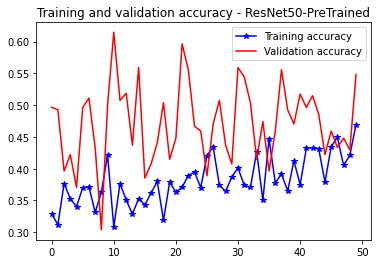

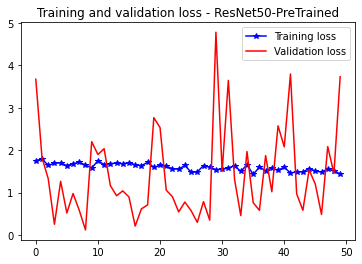

In [39]:
val_acc = resnet_pretrained.history['val_accuracy']
val_loss = resnet_pretrained.history['val_loss']
acc = resnet_pretrained.history['accuracy']
loss = resnet_pretrained.history['loss']

# Plot training & validation accuracy values
plt.plot(range(50), acc, 'b*-', label = 'Training accuracy')
plt.plot(range(50), val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy - ResNet50-PreTrained')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(range(50), loss, 'b*-', label = 'Training loss')
plt.plot(range(50), val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss - ResNet50-PreTrained')
plt.legend()
plt.show()

#**ResNet50**
Defining ResNet50



In [0]:
resnet = ResNet50V2(include_top=False,
                             weights=None,
                             pooling='avg')



Model Building


In [41]:
model = Sequential()

model.add(resnet)
model.add(Dense(6, activation='softmax'))

#Fine-tuning
# Freeze the first layer
#model.layers[0].trainable = False

momentum = 0.001
opt = SGD(learning_rate=lr, momentum=momentum)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 12294     
Total params: 23,577,094
Trainable params: 23,531,654
Non-trainable params: 45,440
_________________________________________________________________


In [42]:
train_step = train_generator.n//train_generator.batch_size
val_step = validation_generator.n//validation_generator.batch_size
print("Train step: ", train_step)
print("Validation step: ", val_step)

Train step:  55
Validation step:  9


Model Training

In [44]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('resnet_checkpoint.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

resnet = model.fit_generator(train_generator,
                   steps_per_epoch=train_step,
                   validation_data=validation_generator,
                   validation_steps=val_step,
                   epochs=50,
                   callbacks=[mc])

Epoch 1/50
55/55 [==============================] - 59s 1s/step - loss: 2.1360 - accuracy: 0.1696 - val_loss: 1.7939 - val_accuracy: 0.2465

Epoch 00001: val_accuracy improved from -inf to 0.24653, saving model to resnet_checkpoint.h5
Epoch 2/50
55/55 [==============================] - 60s 1s/step - loss: 1.9979 - accuracy: 0.2520 - val_loss: 1.8965 - val_accuracy: 0.2222

Epoch 00002: val_accuracy did not improve from 0.24653
Epoch 3/50
55/55 [==============================] - 60s 1s/step - loss: 1.9572 - accuracy: 0.2065 - val_loss: 1.1323 - val_accuracy: 0.2481

Epoch 00003: val_accuracy improved from 0.24653 to 0.24815, saving model to resnet_checkpoint.h5
Epoch 4/50
55/55 [==============================] - 60s 1s/step - loss: 1.8856 - accuracy: 0.2491 - val_loss: 1.8121 - val_accuracy: 0.2222

Epoch 00004: val_accuracy did not improve from 0.24815
Epoch 5/50
55/55 [==============================] - 60s 1s/step - loss: 1.8669 - accuracy: 0.2307 - val_loss: 1.9209 - val_accuracy: 0.

Saving the model

In [0]:
model.save('/content/drive/My Drive/My Models/resnet.h5')
#resnet= models.load_model('/content/drive/My Drive/My Models/resnet.h5')

In [50]:
resnet.model.evaluate_generator(train_generator)

[2.5009777545928955, 0.2514156401157379]

In [47]:
resnet.model.evaluate_generator(validation_generator)

[2.21766996383667, 0.24172185361385345]

In [48]:
resnet.model.evaluate_generator(test_generator)

[2.3571834564208984, 0.2527233064174652]

Visualizing Accuracy and Loss 

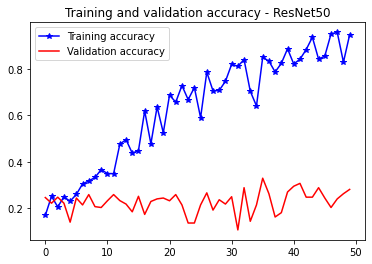

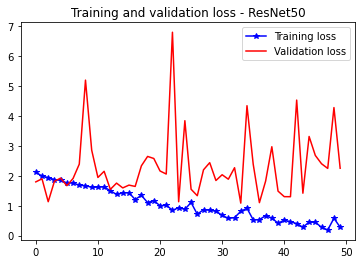

In [51]:
val_acc = resnet.history['val_accuracy']
val_loss = resnet.history['val_loss']
acc = resnet.history['accuracy']
loss = resnet.history['loss']

# Plot training & validation accuracy values
plt.plot(range(50), acc, 'b*-', label = 'Training accuracy')
plt.plot(range(50), val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy - ResNet50')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(range(50), loss, 'b*-', label = 'Training loss')
plt.plot(range(50), val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss - ResNet50')
plt.legend()
plt.show()

# **VGG16 - Pretrained**

Defining VGG

In [8]:
vgg_pretrained = VGG16(weights = 'imagenet',
              include_top = False,
              input_shape = (image_size, image_size,3))
#Fine-tuning
# Freeze the layers except the last 3 layers
for layer in vgg_pretrained.layers[:-3]:
    layer.trainable = False

58892288/58889256 [==============================] - 2s 0us/step


Model Building

In [9]:
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_pretrained)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Nadam(lr=1e-4),
              metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 6150      
Total params: 40,411,974
Trainable params: 30,416,902
Non-trainable params: 9,995,072
_________________________________________________________________


Model Train


In [10]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('vgg-pretrained_checkpoint.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)


vgg_pretrained = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size ,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/validation_generator.batch_size,
    verbose=1,
    callbacks = [mc],)

Epoch 1/50
56/55 [==============================] - 42s 748ms/step - loss: 2.0852 - acc: 0.2939 - val_loss: 2.9771 - val_acc: 0.4503

Epoch 00001: val_acc improved from -inf to 0.45033, saving model to vgg-pretrained_checkpoint.h5
Epoch 2/50
56/55 [==============================] - 33s 590ms/step - loss: 1.3527 - acc: 0.4428 - val_loss: 1.9254 - val_acc: 0.5530

Epoch 00002: val_acc improved from 0.45033 to 0.55298, saving model to vgg-pretrained_checkpoint.h5
Epoch 3/50
56/55 [==============================] - 34s 609ms/step - loss: 1.1290 - acc: 0.5923 - val_loss: 3.4671 - val_acc: 0.5397

Epoch 00003: val_acc did not improve from 0.55298
Epoch 4/50
56/55 [==============================] - 34s 610ms/step - loss: 0.9429 - acc: 0.6438 - val_loss: 2.6787 - val_acc: 0.6126

Epoch 00004: val_acc improved from 0.55298 to 0.61258, saving model to vgg-pretrained_checkpoint.h5
Epoch 5/50
56/55 [==============================] - 34s 605ms/step - loss: 0.7956 - acc: 0.7061 - val_loss: 1.4692 - 

Saving the model

In [0]:
model.save('/content/drive/My Drive/My Models/vgg-pretrained.h5')
#vgg_pretrained_1= models.load_model('/content/drive/My Drive/My Models/vgg-pretrained.h5')

In [12]:
vgg_pretrained.model.evaluate_generator(train_generator)

[2.5072804419323802e-05, 0.9943374991416931]

In [13]:
vgg_pretrained.model.evaluate_generator(validation_generator)

[1.3357126712799072, 0.8245033025741577]

In [14]:
vgg_pretrained.model.evaluate_generator(test_generator)

[5.882878303527832, 0.8104575276374817]

Visualizing Accuracy and Loss 

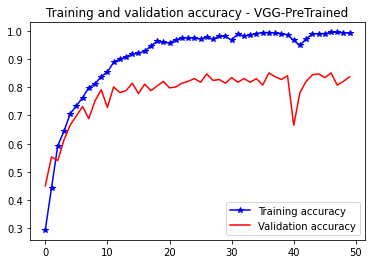

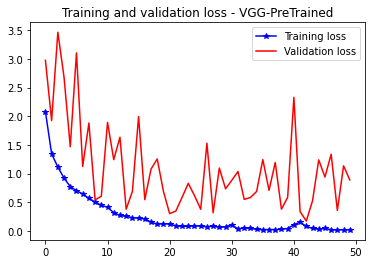

In [15]:
val_acc = vgg_pretrained.history['val_acc']
val_loss = vgg_pretrained.history['val_loss']
acc = vgg_pretrained.history['acc']
loss = vgg_pretrained.history['loss']

# Plot training & validation accuracy values
plt.plot(range(50), acc, 'b*-', label = 'Training accuracy')
plt.plot(range(50), val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy - VGG-PreTrained')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(range(50), loss, 'b*-', label = 'Training loss')
plt.plot(range(50), val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss - VGG-PreTrained')
plt.legend()
plt.show()

# **VGG16**

Defining VGG

In [16]:
vgg = VGG16(weights = None,
              include_top = False,
              input_shape = (image_size, image_size,3))
#Fine-tuning
# Freeze the layers except the last 3 layers
'''for layer in vgg.layers[:-3]:
    layer.trainable = False'''

'for layer in vgg.layers[:-3]:\n    layer.trainable = False'

Model Building

In [17]:
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Nadam(lr=1e-4),
              metrics=['acc'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 6150      
Total params: 40,411,974
Trainable params: 40,411,974
Non-trainable params: 0
_________________________________________________________________


Model Train


In [18]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('vgg_checkpoint.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)


vgg = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size ,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/validation_generator.batch_size,
    verbose=1,
    callbacks = [mc],)

Epoch 1/50
56/55 [==============================] - 60s 1s/step - loss: 1.8658 - acc: 0.0951 - val_loss: 1.8200 - val_acc: 0.2351

Epoch 00001: val_acc improved from -inf to 0.23510, saving model to vgg_checkpoint.h5
Epoch 2/50
56/55 [==============================] - 52s 922ms/step - loss: 2.3714 - acc: 0.2197 - val_loss: 1.9083 - val_acc: 0.2351

Epoch 00002: val_acc did not improve from 0.23510
Epoch 3/50
56/55 [==============================] - 51s 919ms/step - loss: 1.8050 - acc: 0.2293 - val_loss: 2.0054 - val_acc: 0.2351

Epoch 00003: val_acc did not improve from 0.23510
Epoch 4/50
56/55 [==============================] - 51s 917ms/step - loss: 1.7731 - acc: 0.2350 - val_loss: 2.1119 - val_acc: 0.2351

Epoch 00004: val_acc did not improve from 0.23510
Epoch 5/50
56/55 [==============================] - 51s 919ms/step - loss: 1.7576 - acc: 0.2350 - val_loss: 2.5727 - val_acc: 0.2351

Epoch 00005: val_acc did not improve from 0.23510
Epoch 6/50
56/55 [=============================

Saving the model

In [0]:
model.save('/content/drive/My Drive/My Models/vgg.h5')
#vgg= models.load_model('/content/drive/My Drive/My Models/vgg.h5')

In [20]:
vgg.model.evaluate_generator(train_generator)

[2.5789988040924072, 0.2349943369626999]

In [21]:
vgg.model.evaluate_generator(validation_generator)

[2.5790250301361084, 0.23509933054447174]

In [22]:
vgg.model.evaluate_generator(test_generator)

[2.579019784927368, 0.23529411852359772]

Visualizing Accuracy and Loss 

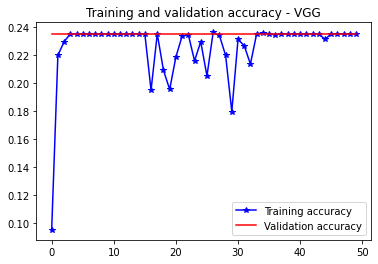

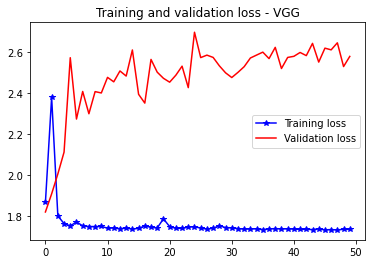

In [23]:
val_acc = vgg.history['val_acc']
val_loss = vgg.history['val_loss']
acc = vgg.history['acc']
loss = vgg.history['loss']

# Plot training & validation accuracy values
plt.plot(range(50), acc, 'b*-', label = 'Training accuracy')
plt.plot(range(50), val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy - VGG')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(range(50), loss, 'b*-', label = 'Training loss')
plt.plot(range(50), val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss - VGG')
plt.legend()
plt.show()

#**Random Sampling of 4 Images for Multiclass Classification**
Combining the 4 Images


In [24]:
img_type=[] #lists the type of 4 images selected at random 
img_filename=[] #lists the filename of the images selected at random

n=100 #number of multiclass images

for i in range(n):
  files=[]  #List of paths of the 4 images selected at random
  waste_types = ['cardboard','glass','metal','paper','plastic','trash']
  image_type=[] #saves the type of image for each iteration
  for j in range(4):
    path = "data/train/"
    folder=random.choice(waste_types)
    if folder in image_type:
      folder=random.choice(waste_types)
    image_type.append(folder)
    path = path +folder
    random_filename = random.choice([
        x for x in os.listdir(path)
        if os.path.isfile(os.path.join(path, x))
    ])
    files.append(path+"/"+random_filename)

  img_type.append(image_type)

#loading the chosen images
  img1=Image.open(files[0])
  img1=img1.resize((112,112))
  img2=Image.open(files[1])
  img2=img2.resize((112,112))
  img3=Image.open(files[2])
  img3=img3.resize((112,112))
  img4=Image.open(files[3])
  img4=img4.resize((112,112))

#creating a blank image of required size
  img= Image.new('YCbCr', (224,224), 'white')
#pasting the selected images into the above image
  img.paste(img1,(0,0,112,112))
  img.paste(img2,(112,0,224,112))
  img.paste(img3,(0,112,112,224))
  img.paste(img4,(112,112,224,224))
  img.show()
  dic='data/Random 4x4/'
  filename='img'+str(i)+'.jpg'
  img_filename.append(filename)
  img.save(dic + filename)
print("Images have been generated and saved")

Images have been generated and saved


Creating dataframe of the file name and classes


In [10]:
df={'Name': img_filename,
    'Classes':img_type}
img_random=pd.DataFrame(df)
img_random.head(5)

,Name,Classes
0,img0.jpg,"[paper, cardboard, metal, plastic]"
1,img1.jpg,"[metal, cardboard, trash, paper]"
2,img2.jpg,"[glass, trash, plastic, paper]"
3,img3.jpg,"[plastic, metal, trash, paper]"
4,img4.jpg,"[cardboard, plastic, glass, trash]"


Generating the image


In [11]:
random_generator = image_augment.flow_from_dataframe(img_random,
                                        directory='data/Random 4x4',
                                        target_size=(image_size,image_size),
                                        x_col="Name",
                                        y_col="Classes",
                                        class_mode='categorical',
                                        shuffle=False,
                                        seed=42)

Found 100 validated image filenames belonging to 6 classes.


Loading the model


In [0]:
cnn= models.load_model('/content/drive/My Drive/My Models/cnn.h5')

Predicting the classes

In [13]:
pred=cnn.predict(random_generator, verbose=1)
pred

4/4 [==============================] - 7s 2s/step


array([[1.99567303e-02, 2.33286479e-03, 3.27905506e-01, 6.35316968e-01,
        1.41953276e-02, 2.92556564e-04],
       [6.35060817e-02, 2.82465369e-02, 2.08847001e-01, 6.71545565e-01,
        1.44464271e-02, 1.34084756e-02],
       [1.71976566e-01, 6.55429661e-02, 4.31232564e-02, 6.69608295e-01,
        4.52027433e-02, 4.54614405e-03],
       [1.00606695e-01, 1.22871399e-01, 2.10242495e-01, 4.74779844e-01,
        8.68057236e-02, 4.69386112e-03],
       [2.38896579e-01, 1.55688152e-01, 2.22740203e-01, 1.73315406e-01,
        4.43085581e-02, 1.65051073e-01],
       [2.31565252e-01, 1.25663668e-01, 1.43121734e-01, 3.51698995e-01,
        8.53403732e-02, 6.26099259e-02],
       [2.16561824e-01, 2.52491266e-01, 3.02819192e-01, 5.50167151e-02,
        1.70192912e-01, 2.91801593e-03],
       [1.45402133e-01, 1.60811216e-01, 7.98948333e-02, 4.07332093e-01,
        1.74627542e-01, 3.19321863e-02],
       [1.22898735e-01, 2.89195120e-01, 1.32607415e-01, 2.03388140e-01,
        1.21181086e-01, 

Extracting the top 4 classes based on the probablities

In [0]:
pred_class=[]

for k in range(n):
  a=[]
  prob_dict={'cardboard': pred[k][0], 'glass' : pred[k][1], 'metal' : pred[k][2], 'paper' : pred[k][3], 'plastic' : pred[k][4], 'trash' : pred[k][5]}
  for i in range(4):
    temp = max(prob_dict, key= prob_dict.get)
    a.append(temp)
    del(prob_dict[temp])
  pred_class.append(a)

Calculating Accuracy

In [15]:
# Depending on correct prediction of classes within an image the accuracy is calculated to be 0 if none, 0.25 if one class is predicted correctly and so on

import collections
prob=[]
for i in range(n):
  a=pred_class[i]
  b=img_type[i]
  c=0
  for j in range(4):
    for k in range(4):
      if a[j] == b[k]:
        c= c+0.25
  prob.append(c)

print("Accuracy = ",(sum(prob)/n)*100, "%")

Accuracy =  72.25 %


Visualising the results

Predicted Classes:  ['metal', 'glass', 'cardboard', 'plastic']


Actual Classes:  ['glass', 'paper', 'plastic', 'metal']




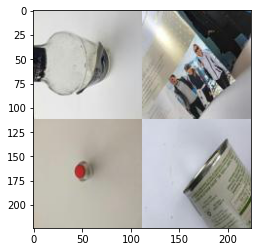

In [18]:
x=random.randint(0,n)
print('Predicted Classes: ', pred_class[x])
print("\n")
print("Actual Classes: ", img_type[x])
print("\n")
filename='img'+str(x)+'.jpg'
path= 'data/Random 4x4/' + filename
image=Image.open(path)
plt.imshow(image, cmap=plt.cm.binary)
